In [77]:
from osgeo import gdal, gdalconst
from sklearn import cross_validation
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import normalize
from matplotlib import pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import KernelDensity
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator
from scipy import stats
from datetime import datetime, date
import os
import pickle
import matplotlib
import calendar
%matplotlib inline

In [13]:
global site_names, latitudes, longitudes, elevations, all_sites, dates
site_names = ['GFL', 'TNY', 'SNF', 'PGM', 'STR']
latitudes = [37.765, 37.838, 37.827, 37.667, 37.637]
longitudes = [-119.773, -119.448, -119.497, -119.625, -119.55]
elevations = [7000., 8150., 8700., 7000., 8200.]
all_sites, dates = get_cdec(site_names, latitudes, longitudes, elevations, '2014-02-01', '2014-05-01')

In [4]:
def resample_lidar(src_fn, dst_fn, pixel_spacing):
    # Source
    src_filename = src_fn
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()
    x_size = src.RasterXSize
    y_size = src.RasterYSize

    # We want a section of source that matches this:
    match_proj = src_proj
    match_geotrans = (src_geotrans[0], pixel_spacing, src_geotrans[2], src_geotrans[3], src_geotrans[4], -pixel_spacing)
    new_x_size = int(x_size * src_geotrans[1] / pixel_spacing)
    new_y_size = int(y_size * src_geotrans[5] / (-pixel_spacing))
    # Output / destination
    dst_filename = dst_fn
    dst = gdal.GetDriverByName('GTiff').Create(dst_filename, new_x_size, new_y_size, 1, gdalconst.GDT_Float32)
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)

    # Do the work
    gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Average)

    del dst # Flush

In [5]:
def reproject_reconstruction(src_fn, match_fn, dst_fn, lidar=False):
    src_filename = src_fn
    src = gdal.Open(src_filename, gdalconst.GA_ReadOnly)
    src_proj = src.GetProjection()
    src_geotrans = src.GetGeoTransform()
    
    # We want a section of source that matches this:
    match_filename = match_fn
    match_ds = gdal.Open(match_filename, gdalconst.GA_ReadOnly)
    match_proj = match_ds.GetProjection()
    match_geotrans = match_ds.GetGeoTransform()
    wide = match_ds.RasterXSize
    high = match_ds.RasterYSize
    
    # Output / destination
    dst_filename = dst_fn
    dst = gdal.GetDriverByName('GTiff').Create(dst_filename, wide, high, 1, gdalconst.GDT_Float32)
    dst.SetGeoTransform( match_geotrans )
    dst.SetProjection( match_proj)
    if not lidar:
        gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Bilinear)
    else:
        gdal.ReprojectImage(src, dst, src_proj, match_proj, gdalconst.GRA_Average)
    del dst

In [29]:
def add_border(image):
    image_shape = image.shape
    new_image = np.zeros((image_shape[0] + 2, image_shape[1] + 2))
    new_image[1:-1, 1:-1] = image
    return new_image

In [6]:
from ulmo import cdec
import pandas as pd
import utm
import numpy as np
from datetime import date, datetime
from sklearn import gaussian_process
from sklearn.preprocessing import Normalizer, Imputer

In [7]:
def get_cdec(site_names, latitudes, longitudes, elevations, start_time, end_time, bool_dates=True):
    all_sites = {}
    aspect = gdal.Open("3m_data/Merced_500m_ASP.tif")
    aspect_raster = aspect.ReadAsArray()
    aspect_georeference = aspect.GetGeoTransform()
    if bool_dates:
        dates = []
    for site, lat, lon, elev in zip(site_names, latitudes, longitudes, elevations):
        temp_data = cdec.historical.get_data([site], [3, 18], 'monthly', start_time, end_time)
        temp_swe = temp_data[site]['3']['value'].values
        temp_sd = temp_data[site]['18']['value'].values
        temp_density = temp_swe / temp_sd

        new_df = pd.DataFrame({'swe, inch': temp_swe, 'sd, inch': temp_sd, 'density': temp_density},
                              index=temp_data[site]['3']['value'].index)
        if bool_dates:
            dates = temp_data[site]['3']['value'].index
        new_dict = {}
        new_dict['data'] = new_df
        new_dict['lat_lon'] = [lat, lon]
        new_dict['elev'] = elev * 0.3048
        new_dict['utm'] = utm.from_latlon(lat, lon)
        new_dict['aspect'] = aspect_raster[int((new_dict['utm'][0] - aspect_georeference[0]) / aspect_georeference[1]),
                                           int((new_dict['utm'][1] - aspect_georeference[3]) / aspect_georeference[5])]
        all_sites[site] = new_dict
    if bool_dates:
        return all_sites, dates
    else:
        return all_sites

In [8]:
def get_spatial_density(all_sites, dates, day_need):
    X = np.empty((0, 3))
    y = np.zeros((len(all_sites), 4))

    for i, (key, info) in enumerate(all_sites.iteritems()):
        utm_location = np.array([np.sqrt(info['utm'][0]**2 + info['utm'][1]**2), info['elev'], info['aspect']])
        X = np.vstack((X, utm_location))
        for j, temp_date in enumerate(dates):
            y[i, j] = info['data']['density'][temp_date]

    dem = gdal.Open('3m_data/Merced_500m_DEM.tif')
    dem_georeference = dem.GetGeoTransform()
    dem_raster = dem.ReadAsArray()
    dem_xRasterSize = dem.RasterXSize
    dem_yRasterSize = dem.RasterYSize
    aspect_raster = gdal.Open('3m_data/Merced_500m_ASP.tif').ReadAsArray()
    y_range = np.arange(dem_georeference[3] + 0.5 * dem_georeference[5], 
                        dem_georeference[3] + (dem_xRasterSize + 0.5) * dem_georeference[5], 
                        dem_georeference[5])
    x_range = np.arange(dem_georeference[0] + 0.5 * dem_georeference[1], 
                        dem_georeference[0] + (dem_yRasterSize + 0.5) * dem_georeference[1], 
                        dem_georeference[1])
    x_grid, y_grid = np.meshgrid(x_range, y_range)
    x_predict = np.column_stack((np.column_stack((np.sqrt((x_grid.flatten()**2 + y_grid.flatten()**2)), 
                                                  dem_raster.flatten())), 
                                 aspect_raster.flatten()))
    x_predict_not_nan_idx = np.where(x_predict[:, 1] > 100.)
    x_predict_new = x_predict[x_predict[:, 1] > 100.]

    imp = Imputer()
    y = imp.fit_transform(y)

    gp = gaussian_process.GaussianProcess(theta0=1e-2, thetaL=1e-4, 
                                          thetaU=1., nugget=0.01, optimizer='Welch', random_start=100)
    gp.fit(X, y[:, 2])
    april_y_total = np.zeros(len(x_predict))
    april_y_total[x_predict_not_nan_idx] = gp.predict(x_predict_new)
    april_y_total = april_y_total.reshape((dem_yRasterSize, dem_xRasterSize))
    
    gp.fit(X, y[:, 3])
    may_y_total = np.zeros(len(x_predict))
    may_y_total[x_predict_not_nan_idx] = gp.predict(x_predict_new)
    may_y_total = may_y_total.reshape((dem_yRasterSize, dem_xRasterSize))
    
    date_y_total = april_y_total + (may_y_total - april_y_total) / 30. * day_need
    
    return date_y_total

In [47]:
def error_analysis(all_sites, dates, day_of_april, tree=True, data=False, shift=False):
    # Calculate snowdensity of the day and get all the spatial data from the folder
    sd_fn = "3m_data/MB201404" + str(day_of_april).zfill(2) + "_500m.tif"
    swe_fn = "3m_data/" + str(day_of_april).zfill(2) + "APR2014_Merced.tif"
    
    # Check if these file existed, if not, resample and reproject them
    if not os.path.isfile(sd_fn):
        src_fn = "3m_data/MB201404" + str(day_of_april).zfill(2) + "_SUPERsnow_depth_EXPORT.tif"
        resample_lidar(src_fn, sd_fn, 500.)
        
    if not os.path.isfile(swe_fn):
        src_fn = "3m_data/" + str(day_of_april).zfill(2) + "APR2014.tif"
        reproject_reconstruction(src_fn, sd_fn, swe_fn)
    
    snow_density = get_spatial_density(all_sites, dates, day_of_april)
    
    # initialize figure for this function
    if not data:
        fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(10, 12))
    
        im = axarr[0, 0].imshow(snow_density, vmin=0.25, vmax=0.4)
        divider = make_axes_locatable(axarr[0, 0])
        cax = divider.append_axes("right", size="10%", pad=0.05)
        cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.05), format="%.2f")
#     plt.show()

    sd_500m = gdal.Open(sd_fn).ReadAsArray()
    swe_500m = gdal.Open(swe_fn).ReadAsArray()
    sd_swe_500m = sd_500m * snow_density
    dem = gdal.Open('3m_data/Merced_500m_DEM.tif').ReadAsArray()
    aspect = gdal.Open('3m_data/Merced_500m_ASP.tif').ReadAsArray()
    slope = gdal.Open('3m_data/Merced_500m_SLP.tif').ReadAsArray()
    northness = gdal.Open('3m_data/Merced_500m_NOR.tif').ReadAsArray()
    vegetation = gdal.Open('3m_data/Merced_500m_CHM.tif').ReadAsArray()
    if shift:
        dem_border = add_border(dem)
        dem_shape = dem.shape
        dem_space = None
        for col_shift in [0, 1, 2]:
            for row_shift in [0, 1, 2]:
                if dem_space is None:
                    temp_dem = dem_border[col_shift:col_shift+dem_shape[0], row_shift:row_shift+dem_shape[1]]
                    dem_space = temp_dem.flatten()
                else:
                    temp_dem = dem_border[col_shift:col_shift+dem_shape[0], row_shift:row_shift+dem_shape[1]]
                    dem_space = np.column_stack((dem_space, temp_dem.flatten()))
        data_space = np.column_stack((np.column_stack((np.column_stack((np.column_stack((np.column_stack((np.column_stack((dem_space, 
                                                                                                                           aspect.flatten())), 
                                                                                                          slope.flatten())),
                                                                        northness.flatten())),
                                                       vegetation.flatten())),
                                      swe_500m.flatten())), 
                     sd_swe_500m.flatten()))
    
    else:
        data_space = np.column_stack((np.column_stack((np.column_stack((np.column_stack((np.column_stack((np.column_stack((dem.flatten(), 
                                                                                                                           aspect.flatten())), 
                                                                                                          slope.flatten())),
                                                                        northness.flatten())),
                                                       vegetation.flatten())),
                                      swe_500m.flatten())), 
                     sd_swe_500m.flatten()))

    # Format the data matrix into expected form
    valid_data_space = data_space[data_space[:, -1] > 0]
    valid_data_space = valid_data_space[valid_data_space[:, -2] > 0]
    lidar_minus_recon = valid_data_space[:, -1] - valid_data_space[:, -2]
    valid_data_space = np.column_stack((valid_data_space, lidar_minus_recon))
    if shift:
        original_outlier_detection_space = valid_data_space[valid_data_space[:, 4] >= 1500., :]
        feature_col_number = np.arange(0, 13, 1)
        feature_col_number = np.append(feature_col_number, [-1])
        original_outlier_detection_space = original_outlier_detection_space[:, feature_col_number]
        outlier_detection_space = original_outlier_detection_space[:, [4, -1]]
    else:
        original_outlier_detection_space = valid_data_space[valid_data_space[:, 0] >= 1500., :]
        original_outlier_detection_space = original_outlier_detection_space[:, [0, 1, 2, 3, 4, -1]]
        outlier_detection_space = original_outlier_detection_space[:, [0, -1]]

    # Outlier rejection using robust covariance estimator
    classifiers = {
        "robust covariance estimator": EllipticEnvelope(contamination=.008)}

    xx, yy = np.meshgrid(np.linspace(1500, 4000, 500), np.linspace(-7, 1, 500))

#     plt.figure(figsize=(10, 5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(outlier_detection_space)
        y_pred = clf.decision_function(outlier_detection_space).ravel()
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * 0.008)
        y_pred = y_pred > threshold
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        if not data:
            subplot = axarr[0, 1]
            subplot.set_title("Outlier detection")
            subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                             cmap=plt.cm.Blues_r)
            a = subplot.contour(xx, yy, Z, levels=[threshold],
                                linewidths=2, colors='red')
            subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                             colors='orange')
            c = subplot.scatter(outlier_detection_space[:, 0], outlier_detection_space[:, 1], c=y_pred)
            subplot.axis('tight')
            subplot.legend(
                [a.collections[0], c],
                ['learned decision function', 'true inliers', 'true outliers'],
                prop=matplotlib.font_manager.FontProperties(size=11), loc=3)
            subplot.set_xlabel("%d. %s" % (i + 1, clf_name))
#     plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#     plt.show()

    clean_data_space = original_outlier_detection_space[y_pred, :]
    
    if data:
        return clean_data_space

    # Calculate the kernel density of the data points in elevation/error 2D space
    '''
    kde = KernelDensity(kernel='gaussian', bandwidth=0.4)
    kde.fit(clean_data_space[:, [0, -1]])
    point_density = np.exp(kde.score_samples(clean_data_space[:, [0, -1]]))
    axarr[1, 0].scatter(clean_data_space[:, 0], clean_data_space[:, -1], c = point_density, edgecolor='none', alpha=0.3)
    axarr[1, 0].set_ylim([-1., 1.])
    '''
#     plt.show()

    axarr[1, 0].hist(clean_data_space[:, -1], bins=30)
    axarr[1, 0].set_xlim([-0.8, 0.8])
#     plt.show()

    # Error analysis versus elevation
    x_train_elev = clean_data_space[:, 0][:, np.newaxis]
    y_train_elev = clean_data_space[:, -1]
    
    if tree:
        dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=10, min_samples_leaf=10)
    else:
        dtr = linear_model.RANSACRegressor(linear_model.LinearRegression())
    dtr.fit(x_train_elev, y_train_elev)
    x_predict_elev = np.linspace(1500, 3600, 100)[:, np.newaxis]
    y_predict_elev = dtr.predict(x_predict_elev)
    axarr[1, 1].scatter(clean_data_space[:, 0], clean_data_space[:, -1], color='k', edgecolor='none')
    axarr[1, 1].plot(x_predict_elev, y_predict_elev, '-b', linewidth=5)
    axarr[1, 1].set_ylim([-1., 1.])
#     plt.show()
    
    y_elev_residual = y_train_elev - dtr.predict(x_train_elev)
    
    
    # Error analysis of each individual feature vs error
    feature_index = [1, 2, 3, 4]
    lower_bound = [0., 0., -1., 0.]
    upper_bound = [360., 90., 1., 10.]
    
    
    for temp_idx, lb, ub in zip(feature_index, lower_bound, upper_bound):
        x_train_feature = clean_data_space[:, temp_idx][:, np.newaxis]
        dtr.fit(x_train_feature, y_elev_residual)
        x_predict_feature = np.linspace(lb, ub, 100)[:, np.newaxis]
        y_predict_feature = dtr.predict(x_predict_feature)
        if temp_idx == 3:
            axarr[2, 0].scatter(clean_data_space[:, temp_idx], y_elev_residual, color='k', edgecolor='none')
            axarr[2, 0].plot(x_predict_feature, y_predict_feature, 'b', linewidth=5)
            axarr[2, 0].set_xlim([-0.2, 0.2])
            axarr[2, 0].set_ylim([-1., 1.])
        if temp_idx == 4:
            axarr[2, 1].scatter(clean_data_space[:, 4], y_elev_residual, color='k', edgecolor='none')
            axarr[2, 1].plot(x_predict_feature, y_predict_feature, 'b', linewidth=5)
            axarr[2, 1].set_xlim([0., 10.])
            axarr[2, 1].set_ylim([-0.5, 0.5])
    
    save_fig_fn = "figures/MB_APR" + str(day_of_april).zfill(2) + ".pdf"
    if not tree:
        save_fig_fn = "figures/MB_APR" + str(day_of_april).zfill(2) + "_ransac.pdf"
#     plt.savefig(save_fig_fn)
    plt.show()

In [10]:
def lidar_recon_anova(site_abbr):
    # date_obj
    if site_abbr == "TB":
        date_obj_list = [date(2014, 3, 23), date(2014, 4, 7), date(2014, 4, 13), date(2014, 4, 20), date(2014, 4, 28)]
    else:
        date_obj_list = [date(2014, 4, 6), date(2014, 4, 14), date(2014, 4, 23), date(2014, 4, 29)]
    
    # Formatting the entire feature space
    error_array_list = []
    all_sites, dates = get_cdec(site_names, latitudes, longitudes, elevations, '2014-02-01', '2014-05-01')
    for date_obj in date_obj_list:
        if site_abbr == "TB":
            feature_space = error_analysis_tb(date_obj, data=True)
        else:
            site_names = ['GFL', 'TNY', 'SNF', 'PGM', 'STR']
            latitudes = [37.765, 37.838, 37.827, 37.667, 37.637]
            longitudes = [-119.773, -119.448, -119.497, -119.625, -119.55]
            elevations = [7000., 8150., 8700., 7000., 8200.]
            feature_space = error_analysis(all_sites, dates, date_obj.day, data=True)
        error_array_list.append(feature_space[:, -1])
    f_val, p_val = stats.f_oneway(*error_array_list)
    print "The p-value of one-way ANOVA is", p_val

In [11]:
def error_analysis_tb(date_of_season, tree=True, data=False):
    # convert date of season to month and day of the month
    month = date_of_season.month
    day = date_of_season.day
    month_name = calendar.month_abbr[month].upper()
    # Calculate snowdensity of the day and get all the spatial data from the folder
    sd_fn = "3m_data/TB2014" + str(month).zfill(2) + str(day).zfill(2) + "_500m.tif"
    swe_fn = "3m_data/" + str(day).zfill(2) + month_name + "2014_Tuolumne.tif"
    
    # Check if these file existed, if not, resample and reproject them
    if not os.path.isfile(sd_fn):
        src_fn = "3m_data/TB2014" + str(month).zfill(2) + str(day).zfill(2) + "_swe.tif"
        reproject_reconstruction(src_fn, "3m_data/Tuolumne_500m_DEM.tif", sd_fn)
        
    if not os.path.isfile(swe_fn):
        src_fn = "3m_data/" + str(day).zfill(2) + month_name + "2014.tif"
        reproject_reconstruction(src_fn, sd_fn, swe_fn)
    
    # initialize figure for this function
    fig, axarr = plt.subplots(ncols=2, nrows=3, figsize=(10, 12))
    
    sd_500m = gdal.Open(sd_fn).ReadAsArray()
    swe_500m = gdal.Open(swe_fn).ReadAsArray()
    sd_swe_500m = sd_500m
    
    im = axarr[0, 0].imshow(sd_swe_500m, vmin = 0, vmax = 1.5)
    divider = make_axes_locatable(axarr[0, 0])
    cax = divider.append_axes("right", size="10%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax, ticks=MultipleLocator(0.3), format="%.2f")
    
    
    dem = gdal.Open('3m_data/Tuolumne_500m_DEM.tif').ReadAsArray()
    aspect = gdal.Open('3m_data/Tuolumne_500m_ASP.tif').ReadAsArray()
    slope = gdal.Open('3m_data/Tuolumne_500m_SLP.tif').ReadAsArray()
    northness = gdal.Open('3m_data/Tuolumne_500m_NOR.tif').ReadAsArray()
    data_space = np.column_stack((np.column_stack((np.column_stack((np.column_stack((np.column_stack((dem.flatten(), 
                                                                                                      aspect.flatten())), 
                                                                                     slope.flatten())),
                                                                    northness.flatten())),
                                                   swe_500m.flatten())), 
                                  sd_swe_500m.flatten()))
    print data_space

    # Format the data matrix into expected form
    valid_data_space = data_space[data_space[:, -1] > 0]
    valid_data_space = valid_data_space[valid_data_space[:, -2] > 0]
    lidar_minus_recon = valid_data_space[:, -1] - valid_data_space[:, -2]
    valid_data_space = np.column_stack((valid_data_space, lidar_minus_recon))
    original_outlier_detection_space = valid_data_space[valid_data_space[:, 0] >= 1500., :]
    original_outlier_detection_space = original_outlier_detection_space[:, [0, 1, 2, 3, -1]]
    outlier_detection_space = original_outlier_detection_space[:, [0, -1]]

    # Outlier rejection using robust covariance estimator
    classifiers = {
        "robust covariance estimator": EllipticEnvelope(contamination=.008)}

    xx, yy = np.meshgrid(np.linspace(1500, 4000, 500), np.linspace(-7, 1, 500))

#     plt.figure(figsize=(10, 5))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(outlier_detection_space)
        y_pred = clf.decision_function(outlier_detection_space).ravel()
        threshold = stats.scoreatpercentile(y_pred,
                                            100 * 0.008)
        y_pred = y_pred > threshold
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = axarr[0, 1]
        subplot.set_title("Outlier detection")
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        c = subplot.scatter(outlier_detection_space[:, 0], outlier_detection_space[:, 1], c=y_pred)
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11), loc=3)
        subplot.set_xlabel("%d. %s" % (i + 1, clf_name))
#     plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
#     plt.show()

    clean_data_space = original_outlier_detection_space[y_pred, :]
    if data:
        return clean_data_space
    
    # Calculate the kernel density of the data points in elevation/error 2D space
    kde = KernelDensity(kernel='gaussian', bandwidth=0.4)
    kde.fit(clean_data_space[:, [0, -1]])
    point_density = np.exp(kde.score_samples(clean_data_space[:, [0, -1]]))
    axarr[1, 0].scatter(clean_data_space[:, 0], clean_data_space[:, -1], c = point_density, edgecolor='none', alpha=0.3)
    axarr[1, 0].set_ylim([-1., 1.])
#     plt.show()

    axarr[1, 1].hist(clean_data_space[:, -1], bins=30)
    axarr[1, 1].set_xlim([-0.8, 0.8])
#     plt.show()

    # Error analysis versus elevation
    x_train_elev = clean_data_space[:, 0][:, np.newaxis]
    y_train_elev = clean_data_space[:, -1]
    
    if tree:
        dtr = DecisionTreeRegressor(max_depth=4, min_samples_split=10, min_samples_leaf=10)
    else:
        dtr = linear_model.RANSACRegressor(linear_model.LinearRegression())
    dtr.fit(x_train_elev, y_train_elev)
    x_predict_elev = np.linspace(1500, 3600, 100)[:, np.newaxis]
    y_predict_elev = dtr.predict(x_predict_elev)
    axarr[2, 0].scatter(clean_data_space[:, 0], clean_data_space[:, -1], color='k', edgecolor='none')
    axarr[2, 0].plot(x_predict_elev, y_predict_elev, '-b', linewidth=5)
    axarr[2, 0].set_ylim([-1., 1.])
#     plt.show()
    
    y_elev_residual = y_train_elev - dtr.predict(x_train_elev)
    
    
    # Error analysis of each individual feature vs error
    feature_index = [1, 2, 3]
    lower_bound = [0., 0., -1.]
    upper_bound = [360., 90., 1.]
    
    
    for temp_idx, lb, ub in zip(feature_index, lower_bound, upper_bound):
        x_train_feature = clean_data_space[:, temp_idx][:, np.newaxis]
        dtr.fit(x_train_feature, y_elev_residual)
        x_predict_feature = np.linspace(lb, ub, 100)[:, np.newaxis]
        y_predict_feature = dtr.predict(x_predict_feature)
        if temp_idx == 3:
            axarr[2, 1].scatter(clean_data_space[:, temp_idx], y_elev_residual, color='k', edgecolor='none')
            axarr[2, 1].plot(x_predict_feature, y_predict_feature, 'b', linewidth=5)
            axarr[2, 1].set_xlim([-0.2, 0.2])
            axarr[2, 1].set_ylim([-1., 1.])
    save_fig_fn = "figures/TB_" + month_name + str(day).zfill(2) + ".pdf"
    if not tree:
        save_fig_fn = "figures/TB_" + month_name + str(day).zfill(2) + "_ransac.pdf"
    plt.savefig(save_fig_fn)
    plt.show()

In [68]:
def getData(site_abbr, date_time, cv=False, kfold=False, shift=False):
    if cv and kfold:
        print "Cross validation and k-fold cannot be true at the same time"
        return 0
    if site_abbr == "MB":
        day_of_april = date_time.day
        data_table = error_analysis(all_sites, dates, day_of_april, data=True, shift=shift)
        feature = data_table[:, 0:-1]
        predict_y = data_table[:, -1]
        if cv:
            X_train, X_test, y_train, y_test = cross_validation.train_test_split(feature, predict_y, test_size=0.4,
                                                                                 random_state=0)
            return X_train, X_test, y_train, y_test
        elif kfold:
            KFold_obj = KFold(n=len(feature), n_folds=5, shuffle=True, random_state=None)
            return feature, predict_y, KFold_obj
        else:
            return feature, predict_y

In [128]:
# For a particular day of the lidar observation, check the kernel density estimation of the error. Then fit the best 
# fitted random forest regression model to the data and check how does the error density changes with regard the 
# initial error
def randomForestPredict(site_abbr, date_time, shift=False, kFold=False, cv=True):
    
    n_est_list = np.arange(10, 100, 10)
    n_min_samples_leaf = np.arange(10, 50, 10)
    error = np.zeros((len(n_est_list), len(n_min_samples_leaf)))
    if kFold:
        feature, predict_y, kf = getData(site_abbr, date_time, shift=shift, kfold=True)
        for i, n_est in enumerate(n_est_list):
            print i
            for j, n_sl in enumerate(n_min_samples_leaf):
                rf = RandomForestRegressor(n_estimators=n_est, max_features='auto', min_samples_leaf=n_sl, n_jobs=10)
                y_predict_list = np.empty(1)
                y_test_list = np.empty(1)
                for train_index, test_index in kf:
                    [X_train, X_test, y_train, y_test] = [feature[train_index], feature[test_index], 
                                                          predict_y[train_index], predict_y[test_index]]
                    rf.fit(X_train, y_train)
                    k_fold_predict = rf.predict(X_test)
                    y_predict_list = np.append(y_predict_list, k_fold_predict)
                    y_test_list = np.append(y_test_list, y_test)
                rmse = np.sqrt(mean_squared_error(y_test_list, y_predict_list))
                error[i, j] = rmse
    elif cv:
        X_train, X_test, y_train, y_test = getData(site_abbr, date_time, shift=shift, kfold=False, cv=True)
        for i,n_est in enumerate(n_est_list):
            print i
            for j,n_sl in enumerate(n_min_samples_leaf):
                rf = RandomForestRegressor(n_estimators=n_est, max_features='auto', min_samples_leaf=n_sl, 
                                           n_jobs=10)
                rf.fit(X_train, y_train)
                y_predict = rf.predict(X_test)
                mse = mean_squared_error(y_test, y_predict)
                error[i, j] = np.sqrt(mse)
    min_error_idx = np.where(error==np.min(error))
    n_est_opt = n_est_list[min_error_idx[0]]
    n_sl_opt = n_min_samples_leaf[min_error_idx[1]]
    feature, predict_y = getData(site_abbr, date_time, shift=shift)
    final_model = RandomForestRegressor(n_estimators=n_est_opt, max_features='auto', min_samples_leaf=n_sl_opt, n_jobs=10)
    final_model.fit(feature, predict_y)
    if shift:
        final_model_fn = "regression_models/" + site_abbr + "_" + date_time.strftime("%y_%m_%d") + "_shift_rf.p"
    else:
        final_model_fn = "regression_models/" + site_abbr + "_" + date_time.strftime("%y_%m_%d") + "_rf.p"
    pickle.dump(final_model, open(final_model_fn, "wb"))
    return error, n_est_opt, n_sl_opt

In [136]:
def calculate_1d_kernel_density(X, linspace):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(X[:, np.newaxis])
    density = kde.score_samples(linspace)
    return np.exp(density)

In [137]:
def plot_err_dist_before_and_after(site_abbr, date_time, shift=False):
    if site_abbr == "MB":
        feature, y = getData(site_abbr, date_time, shift=shift)
        y_linspace = np.linspace(-0.5, 0.5, 200)[:, np.newaxis]
        y_density = calculate_1d_kernel_density(y, y_linspace)
        plt.plot(y_linspace, y_density)
        if shift:
            rf_model_fn = "regression_models/" + site_abbr + "_" + date_time.strftime("%y_%m_%d") + "_shift_rf.p"
        else:
            rf_model_fn = "regression_models/" + site_abbr + "_" + date_time.strftime("%y_%m_%d") + "_rf.p"
        rf_model = pickle.load(open(rf_model_fn, "rb"))
        y_predict = rf_model.predict(feature)
        y_diff = y - y_predict
        y_predict_density = calculate_1d_kernel_density(y_diff, y_linspace)
        plt.plot(y_linspace, y_predict_density)
        plt.legend(["Original", "Corrected"])

/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/base.py:106: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  n_estimators_per_job[:n_estimators % n_jobs] += 1
/usr/local/lib/python2.7/dist-packages/sklearn/ensemble/base.py:106: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  n_estimators_per_job[:n_estimators % n_jobs] += 1


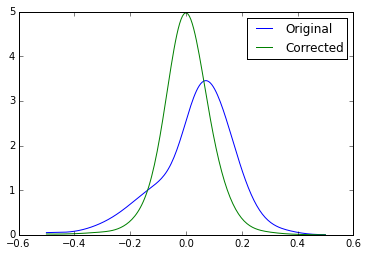

0
1
2
3
4
5
6
7
8


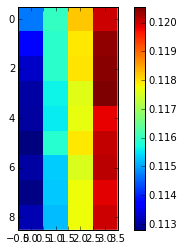

0
1
2
3
4
5
6
7
8


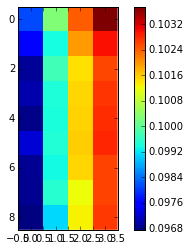

0
1
2
3
4
5
6
7
8


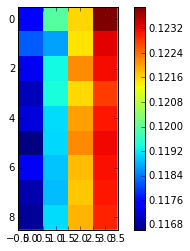

0
1
2
3
4
5
6
7
8


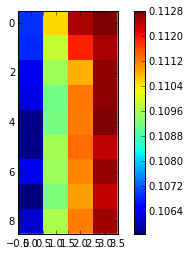

0
1
2
3
4
5
6
7
8


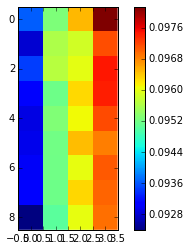

0
1
2
3
4
5
6
7
8


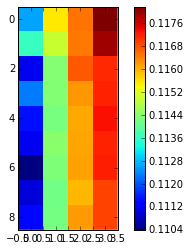

In [139]:
date_time_list = [datetime(2014, 4, 14), datetime(2014, 4, 23), datetime(2014, 4, 29)]
for temp_date_time in date_time_list:
    rmse, n_est_opt, n_sl_opt = randomForestPredict("MB", temp_date_time, shift=False, kFold=True)
    plt.imshow(rmse, vmin = np.min(rmse), vmax = np.max(rmse), interpolation='none')
    plt.colorbar()
    plt.show()

# This one is with 9 grids of dem features
for temp_date_time in date_time_list:
    rmse, n_est_opt, n_sl_opt = randomForestPredict("MB", temp_date_time, shift=True, kFold=True)
    plt.imshow(rmse, vmin = np.min(rmse), vmax = np.max(rmse), interpolation='none')
    plt.colorbar()
    plt.show()

In [ ]:
def main():
    site_names = ['GFL', 'TNY', 'SNF', 'PGM', 'STR']
    latitudes = [37.765, 37.838, 37.827, 37.667, 37.637]
    longitudes = [-119.773, -119.448, -119.497, -119.625, -119.55]
    elevations = [7000., 8150., 8700., 7000., 8200.]
    all_sites, dates = get_cdec(site_names, latitudes, longitudes, elevations, '2014-02-01', '2014-05-01')

#     date_list = [datetime(2014, 3, 23), datetime(2014, 4, 7), datetime(2014, 4, 13), datetime(2014, 4, 20), datetime(2014, 4, 28)]
#     for temp_date in date_list:
#         error_analysis_tb(temp_date, tree=False)

    for day_num in [6, 14, 23, 29]:
    # for day_num in [6]:
        error_analysis(all_sites, dates, day_num, tree=True)

In [ ]:
if __name__ == "__main__":
    main()